In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import configparser
from src.clustering.algorithm_wrappers.KMeansWrapper import KMeansWrapper
from src.clustering.algorithm_wrappers.AgglomerativeWrapper import AgglomorativeWrapper
from src.clustering.algorithm_wrappers.OpticsWrapper import OpticsWrapper
import umap
import matplotlib.pyplot as plt


/home/vera/anaconda3/envs/04-continous-user-feedback/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/vera/anaconda3/envs/04-continous-user-feedback/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/vera/anaconda3/envs/04-conti

In [23]:
config = configparser.ConfigParser()
config.read('../../config.ini')
embedding_path = '../../' + config['DATA']['UserEmbeddingPath']
test_path = '../../' + config['DATA']['TestUserEmbeddingPath']


In [3]:
user_embedding = np.load(embedding_path)
test_embedding = np.load(test_path)


In [4]:
N_NEIGHBORS= int(config['UMAP']['n_neighbors'])
MIN_DIST= float(config['UMAP']['min_dist'])
N_COMPONENTS= int(config['UMAP']['n_components'])
METRIC=config['UMAP']['metric']
fit = umap.UMAP(
    n_neighbors= N_NEIGHBORS,
    min_dist= MIN_DIST,
    n_components= N_COMPONENTS,
    metric=METRIC
)
user_reduced = fit.fit_transform(user_embedding)
test_reduced = fit.transform(test_embedding)


# Performance metrics
Measure the cluster quality. For details on metrics see: `https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation`.
Note that this is not suitable to decide between different clustering techniques, as the values for density-based clustering are per-se lower, but very useful to choose hyperparameters for one clustering algorithm.
Options are
* 'chi'=Calinski-Harabasz Index: ratio of the sum of between-clusters dispersion and of within-cluster dispersion for all clusters. The higher the better.
 * or 'dbi'=Davies-Bouldin Index: average ‘similarity’ between clusters, where the similarity is a measure that compares the distance between clusters with the size of the clusters themselves. The lower the better.


In [5]:
kmeans_model = KMeansWrapper()
kmeans_model.train(user_reduced)
print(f"CHI score: {kmeans_model.measure_performance(user_reduced, 'chi')}")
print(f"DBI score: {kmeans_model.measure_performance(user_reduced, 'dbi')}")


CHI score: 1032.9800192099187
DBI score: 0.95610197100508


In [6]:
chi = []
dbi = []
for no_clusters in range(2, 100):
    kmeans_model = KMeansWrapper()
    kmeans_model.n_clusters = no_clusters
    kmeans_model.train(user_reduced)
    chi.append(kmeans_model.measure_performance(user_reduced, 'chi'))
    dbi.append(kmeans_model.measure_performance(user_reduced, 'dbi'))
print(f"Max CHI score: {max(chi)} at {np.argmax(chi)+2} clusters")
print(f"Min DBI score: {min(dbi)} at {np.argmin(dbi)+2} clusters")

Max CHI score: 1391.14734423468 at 3 clusters
Min DBI score: 0.7697639289255488 at 94 clusters


# Choosing representative
        Calculates the representats for each cluster using the model stored at self.model.
        This can occur in two ways:
        1. centroid: The mean of all points in the cluster. This is not a real user, and is not representative if
        the cluster is curved.
        2. medoids: The cluster point which is closest to the centroid.

## 1. Kmeans
### Centroid

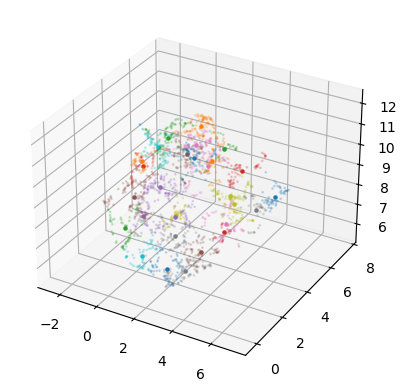

In [7]:
kmeans_model = KMeansWrapper()
kmeans_model.train(user_reduced)
kmeans_model.extract_representations(user_reduced, mode='centroid') # return tuple (clusterid, location)
kmeans_model.visualize(user_reduced)

### Medoid

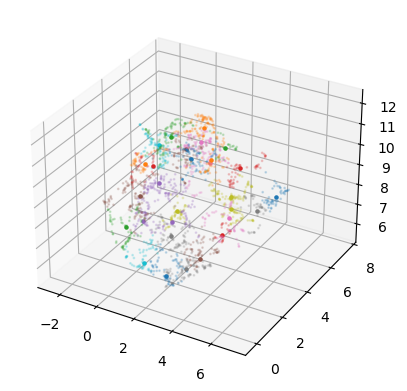

In [8]:
kmeans_model = KMeansWrapper()
kmeans_model.train(user_reduced)
kmeans_model.extract_representations(user_reduced, mode='medoid') # return tuple (clusterid, location)
kmeans_model.visualize(user_reduced)


## 2. Agglomorative
### Centroid

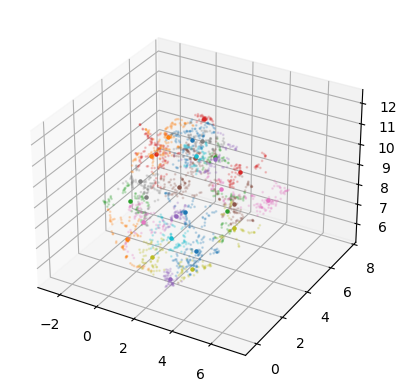

In [9]:
agg_model = AgglomorativeWrapper()
agg_model.extract_representations(user_reduced, mode='centroid')  # return tuple (clusterid, location)
agg_model.visualize(user_reduced)

### Medoid

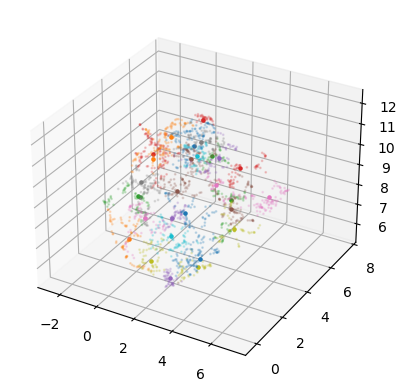

In [10]:
agg_model = AgglomorativeWrapper()
agg_model.extract_representations(user_reduced, mode='medoid')  # return tuple (clusterid, location)
agg_model.visualize(user_reduced)


## Suggestion

In [11]:
kmeans_model = KMeansWrapper()
kmeans_model.train(user_reduced)
kmeans_model.extract_representations(user_reduced, mode='medoid') # return tuple (clusterid, location)
prediction = kmeans_model.predict(test_reduced[0])
cluster_representant = kmeans_model.interpret(prediction)

Would you like to see a user from 10


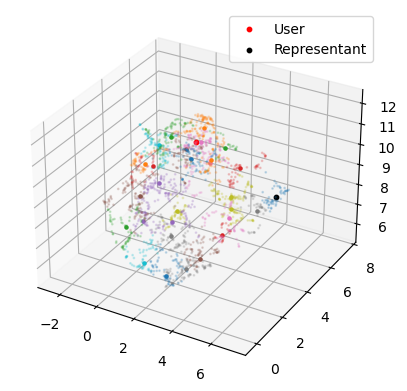

In [19]:
suggestion_label, suggestion_location = kmeans_model.suggest(cluster_representant, metric='max')
print(f"Would you like to see a user from {suggestion_label}")
kmeans_model.visualize(user_reduced, test_reduced[0], suggestion_location)


Would you like to see a user from 12


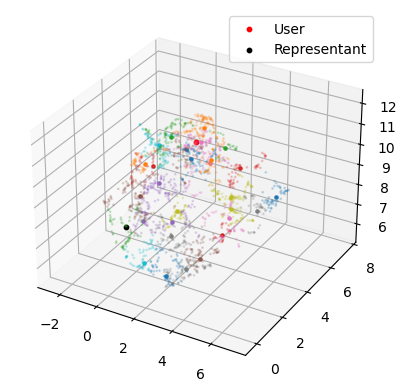

In [24]:
suggestion_label, suggestion_location = kmeans_model.suggest(cluster_representant, metric=config['Clustering']['SuggestionMetric'])
print(f"Would you like to see a user from {suggestion_label}")
kmeans_model.visualize(user_reduced, test_reduced[0], suggestion_location)


Would you like to see a user from 16


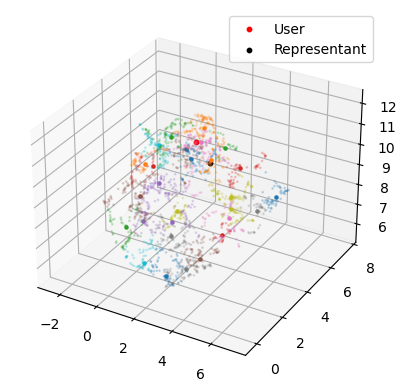

In [21]:
suggestion_label, suggestion_location = kmeans_model.suggest(cluster_representant, metric='0.1')
print(f"Would you like to see a user from {suggestion_label}")
kmeans_model.visualize(user_reduced, test_reduced[0], suggestion_location)
